# Tutorial 2: VANs loop

In this tutorial we will train VANs to find a quantum circuit that prepares the ground state of a TFIM, by departing from a separable circuit.

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import cirq
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.chdir("..")
print("USING TFQ {} VERSION ".format(tfq.__version__))
print("USING CIRQ {} VERSION ".format(cirq.__version__))

USING TFQ 0.4.0 VERSION 
USING CIRQ 0.9.1 VERSION 


As in the previous tutorial, we will work with the TFIM

$H=-J\sum_{j=1}^n \sigma_j^x\sigma_{j+1}^x-g\sum_{j=1}^n \sigma_j^x\,,$

### Introducing the Evaluator

Evaluator is a method that allows VANs to keep track of quantum circuit evolution, and eventually load results for future analysis. Moreover, it literally evaluates to whether or not accept a new quantum circuit according to some criteria. In this case, the criteria we have implemented is a very simple one: we accept modifications whose energy is $\epsilon$-close to the best energy found so far. The reason we do this is to favour exploration, and $\epsilon$ is decreased as VANs iterations evolve.

Evaluator keeps a record of training according with two dictionaries: $\texttt{raw_history}$ and $\texttt{evolution}$. In $\texttt{raw_history}$ we keep everything, whereas in $\texttt{evolution}$ we keep only changes that are approved by the Evaluator. Either adding information to both dictionaries or not is controlled by the argument $relevant$ of the <i>add_step</i> function.

Now let us go through the algorithm; this is explained in the paper but for the record we will put the pseudo-code


<img src="images/vans_algo.png" alt="Italian Trulli">

In [42]:
from utilities.circuit_basics import Basic, overlap
from utilities.variational import VQE 
from utilities.evaluator import Evaluator
from utilities.idinserter import IdInserter
from utilities.simplifier import Simplifier
from utilities.unitary_killer import UnitaryMurder
from utilities.evaluator import Evaluator


In [47]:
problem_config={"problem":"TFIM", "J":1.0, "g":1.0}

vqe_handler = VQE(n_qubits=4, epochs=2000, 
                  verbose=1,problem_config=problem_config,
                  optimizer="adam", lr=0.01)


dict_evaluator={"n_qubits":4,"problem_config":problem_config}

evaluator = Evaluator(dict_evaluator, path="examples_repository/", acceptance_percentage=1e-3, 
                      reduce_acceptance_percentage=True)

training_histories = {}

iid = IdInserter(n_qubits=len(vqe_handler.qubits),
                 selector_temperature = 10.0)

Simp = Simplifier(n_qubits=len(vqe_handler.qubits))

vqe_handler = VQE(n_qubits=4, epochs=5000, 
                  verbose=0,problem_config=problem_config,
                  optimizer="adam", lr=1e-2, patience=100)

unitary_killer = UnitaryMurder(vqe_handler, accept_wall=100)


We begin with a separable circuit

In [48]:
indexed_circuit = [vqe_handler.number_of_cnots+vqe_handler.n_qubits+k for k in range(vqe_handler.n_qubits)]
display(vqe_handler.give_circuit(indexed_circuit)[0])

(0, 0): ───Rx(th_0)───

(0, 1): ───Rx(th_1)───

(0, 2): ───Rx(th_2)───

(0, 3): ───Rx(th_3)───

In [49]:
energy, symbol_to_value, training_history = vqe_handler.vqe(indexed_circuit)
training_histories[len(list(training_histories.keys()))] = training_history

## add step to evaluator ##
evaluator.add_step(indexed_circuit, symbol_to_value, energy, relevant=True)
evaluator.lowest_energy = energy


Now let us go on with the algorithm.

In [50]:
for iteration in range(15):
    M_indices, M_symbols_to_values, M_idx_to_symbols = iid.place_identities(indexed_circuit, symbol_to_value, rate_iids_per_step= 2.0)

    ### simplify the circuit as much as possible
    Sindices, Ssymbols_to_values, Sindex_to_symbols = Simp.reduce_circuit(M_indices, M_symbols_to_values, M_idx_to_symbols)

    ## compute the energy of the mutated-simplified circuit [Note 1]
    MSenergy, MSsymbols_to_values, training_history = vqe_handler.vqe(Sindices, symbols_to_values=Ssymbols_to_values, parameter_perturbation_wall=np.pi/10.)
    training_histories[len(list(training_histories.keys()))] = training_history


    if evaluator.accept_energy(MSenergy):
        #delete as many 1-qubit gates as possible, as long as the energy doesn't go up (we allow %1 increments per iteration)
        indexed_circuit, symbol_to_value, index_to_symbols = Sindices, MSsymbols_to_values, Sindex_to_symbols

        cnt=0
        reduced=True
        lmax=len(indexed_circuit)
        while reduced and cnt < lmax:
            indexed_circuit, symbol_to_value, index_to_symbols, energy, reduced = unitary_killer.unitary_slaughter(indexed_circuit, symbol_to_value, index_to_symbols, reference_energy = MSenergy)
            indexed_circuit, symbol_to_value, index_to_symbols = Simp.reduce_circuit(indexed_circuit, symbol_to_value, index_to_symbols)
            cnt+=1
        print("Accepted circuit! Actually I reduced it from {} to {}. With this, energy increased {}".format(len(Sindices), len(indexed_circuit), MSenergy-energy))
        relevant=True

    evaluator.add_step(indexed_circuit, symbol_to_value, energy,relevant=relevant)
    to_print=f"iteration: {iteration} \n"\
            f"best energy {evaluator.lowest_energy} \n"\
            f"current energy {energy}\n"\
            f"Number of params {vqe_handler.count_params(indexed_circuit)}\n"\
            f"Number of CNOTs {vqe_handler.count_cnots(indexed_circuit)}\n"
    print(to_print)
    evaluator.save_dicts_and_displaying()

Accepted circuit! Actually I reduced it from 16 to 6. With this, energy increased -2.384185791015625e-06
iteration: 0 
best energy -4.472135543823242 
current energy -4.472135543823242
Number of params 4
Number of CNOTs 2

Accepted circuit! Actually I reduced it from 41 to 26. With this, energy increased -0.13541936874389648
iteration: 1 
best energy -5.090827941894531 
current energy -5.090827941894531
Number of params 16
Number of CNOTs 10

Accepted circuit! Actually I reduced it from 53 to 29. With this, energy increased -0.029964923858642578
iteration: 2 
best energy -5.196290493011475 
current energy -5.196290493011475
Number of params 17
Number of CNOTs 12

Accepted circuit! Actually I reduced it from 37 to 27. With this, energy increased -0.002788543701171875
iteration: 3 
best energy -5.223462104797363 
current energy -5.223462104797363
Number of params 15
Number of CNOTs 12

Accepted circuit! Actually I reduced it from 39 to 25. With this, energy increased -1.7642974853515625e

In [27]:
circuits = [list(evaluator.raw_history.values())[k][0] for k in range(len(evaluator.raw_history.keys()))]
energies = [list(evaluator.raw_history.values())[k][1] for k in range(len(evaluator.raw_history.keys()))]

No handles with labels found to put in legend.


Text(0, 0.5, 'Energy')

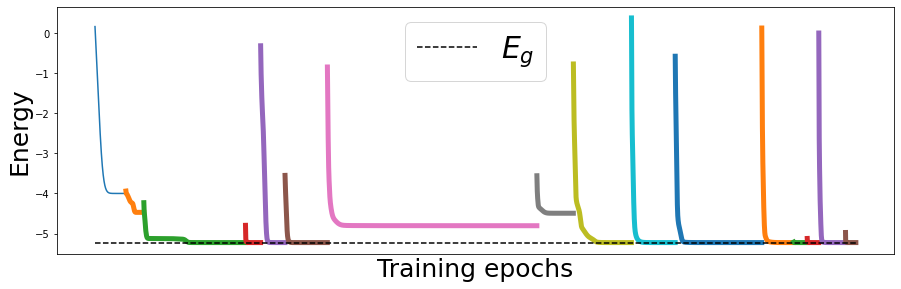

In [61]:
### Let's compute the ground-state:
H=sum(vqe_handler.observable).matrix()
eigs = np.linalg.eigh(H)
ground_state_energy = eigs[0][0]
ground_state = eigs[1][:,0]

lw=5
ls=30
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.xticks([])
plt.legend(prop={"size":30})

indlast=0
en = list(training_histories.values())[0].history["energy"]
indlast+=len(en)
plt.plot(range(indlast), en)
for ind,eng in enumerate(list(training_histories.values())[1:]):
    en = eng.history["energy"]
    plt.plot( range(indlast, indlast+len(en)), en, linewidth=lw)
    indlast+=len(en)
plt.plot([0,indlast],np.ones(2)*ground_state_energy, '--',label=r'$E_g$', color="black")
plt.legend(prop={"size":30})
plt.xlabel("Training epochs",size=25)
plt.ylabel("Energy",size=25)

Note that kinks appear due to parameter initialization when doing VQE (in turn, this can allow to exit local minima, and is a parameter that can be controlled in vqe algorithm, find it in variational.py!).

Finally, note that evaluator can be used to load data as well (note that nrun_load=0 is used, but if the problem w/ same configuration is run more a subdirectory with nrun=L (L=#of runs) so to store results.

In [64]:
problem_config={"problem":"TFIM", "J":1.0, "g":1.0}

vqe_handler = VQE(n_qubits=4, epochs=2000, 
                  verbose=1,problem_config=problem_config,
                  optimizer="adam", lr=0.01)

dict_evaluator={"n_qubits":4,"problem_config":problem_config}

evaluator_loading = Evaluator(dict_evaluator, path="examples_repository/",loading=True, nrun_load=0)

In [65]:
best_energies = []
for k in list(evaluator_loading.evolution.values()):
    best_energies.append(k[1])

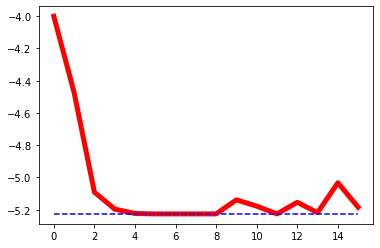

In [70]:
plt.plot(best_energies, linewidth=lw, color="red")
plt.plot(np.ones(len(best_energies))*ground_state_energy,'--', color="blue")
pl